---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
print('[INFO] -> Using Device: ', device)

[INFO] -> Using Device:  cpu


In [3]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y


def get_CoverType(PATH, seed, scale = True, show = False):
    
    df = pd.read_csv(PATH, header = None)
    discreteCol = np.arange(10, len(df.columns)-1)
    
    labels = df[54].copy()
    labels.replace({1: 0, 2: 0, 3: 0, 4:1, 5:1, 6:1, 7:1}, inplace = True)
    df[54] = labels

    normal = df[df[54] == 0] 
    abnormal = df[df[54] == 1]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)

    abnormal_1 = abnormal[:int(len(abnormal)*.5)+1]
    abnormal_2 = abnormal[int(len(abnormal)*.5)+1:]

    test_size_ab = int(len(abnormal_1)*(3/4))
    val_size_ab = int(len(abnormal_1)*(1/4))+1

    test_size_n = int(.15 * (len(normal) + len(abnormal_1)) - test_size_ab)
    val_size_n = int(.05 * (len(normal) + len(abnormal_1)) - val_size_ab)

    train_size = int(len(normal) - val_size_n - test_size_n)

    train_set = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size_n]
    test_normal = normal[train_size+val_size_n: ]

    val_abnormal = abnormal_1[:val_size_ab]
    test_abnormal = abnormal_1[val_size_ab:val_size_ab+test_size_ab]

    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))

    x_train, y_train = _to_xy(train_set, target=54)
    x_val, y_val = _to_xy(val_set, target=54)
    x_test, y_test = _to_xy(test_set, target=54)
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print(f'We use {len(abnormal_1)} anomalous records')
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == 0])} normal records and {len(x_train[y_train == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == 0])} normal records and {len(x_val[y_val == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == 0])} normal records and {len(x_test[y_test == 1])} abnormal records')

    selected_columns = dict()
    
    for name in discreteCol:
        selected_columns[name] = x_train.columns.get_loc(name)
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
    
    index = index = np.arange(0, len(df.columns)-len(discreteCol)-1)

    if scale:
        scaler = MinMaxScaler()
        scaler.fit(x_train[:, index])
        x_train[:, index] = scaler.transform(x_train[:, index])
        x_val[:, index] = scaler.transform(x_val[:, index])
        x_test[:, index] = scaler.transform(x_test[:, index])
        
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['selectedColumns'] = selected_columns
    dataset['discreteCol'] = discreteCol
    dataset['index'] = index
    dataset['scaler'] = scaler
    
    return dataset

In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
FILE = 'covtype.data'

DATASET = 'CoverType'

PATH = os.path.join(WORK_SPACE, DATASET, FILE)

In [5]:
dataset = get_CoverType(PATH, seed, show=True)

530895 normal records, 50117 anormal records
We use 25059 anomalous records
-----------------------------------------------------------------------------------------
There are 444764 records in training set
Training set is composed by 444764 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 27797 records in validation set
Validation set is composed by 21532 normal records and 6265 abnormal records
-----------------------------------------------------------------------------------------
There are 83393 records in test set
Test set is composed by 64599 normal records and 18794 abnormal records


## Model

In [6]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1).to(device)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y


class Autoencoder(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Autoencoder, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), # 121@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out), # 64@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out, self.z_dim), # 32@16
            nn.BatchNorm1d(self.z_dim, track_running_stats = False),
            nn.LeakyReLU(0.2)
        
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.nf_out), # 16@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.ReLU(),
            
            nn.Linear(self.nf_out, self.nf_out * 2), # 32@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_in) # 64@121
        )
        
        self.sigmoid = nn.Sigmoid()

        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x, text_l, selected_columnsTrain, index, t=1):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        rec = dec.clone()
        rec[:, index] = self.sigmoid(dec[:, index])
        for name in text_l:
            rec[:, selected_columnsTrain[name]] = self.gumbel(dec[:, selected_columnsTrain[name]], t)
        
        return rec
    
    
class Loss(nn.Module):
    def __init__(self, text_l, selected_columnsTrain, index):
        super(Loss, self).__init__()
        
        self.text_l = text_l
        self.selected_columnsTrain = selected_columnsTrain
        self.index = index
        
        self.mse = nn.MSELoss(reduction = 'mean')
    
    def reconstruction(self, true_data, rec_data):
        g1 = self.mse(true_data[:, self.index], rec_data[:, self.index])
        g2 = 0
        for name in self.text_l:
            y = true_data[:, self.selected_columnsTrain[name]]
            y_p = rec_data[:, self.selected_columnsTrain[name]]
            g2 += self.mse(y_p, y)
        g2 /= len(self.text_l)
        return g1 + 0.5 * g2

    def forward(self, true_data, rec_data):
        rec = self.reconstruction(true_data, rec_data)
        return rec
    

class BaselineTrainer(nn.Module):
    def __init__(self, device, selected_columns, discreteCol, index, nc):
        super(BaselineTrainer, self).__init__()
        self.device = device
        self.selected_columns = selected_columns
        self.discreteCol = discreteCol
        self.index = index
        self.nc = nc

        self.AE = Autoencoder(nf_in = self.nc).to(self.device)

        self.ae_optimizer = torch.optim.Adam(self.AE.parameters(), lr=1e-4)
        self.loss = Loss(self.discreteCol, self.selected_columns, self.index)
        
        self.temperature = 1
        self.anneal = 0.9995
        self.criterion = nn.MSELoss(reduction = 'mean')

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
            
    def evaluation(self, test_loader):
        self.AE.eval()
        aeL = []
    
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                rec_data = self.AE(batch, self.discreteCol, self.selected_columns, self.index, self.temperature)   
                ae_loss_batch = self.loss(batch, rec_data)
                
            aeL.append(ae_loss_batch.item())
            
        return np.mean(aeL)
    
    
        
        
    def AE_step(self, true_data):
        self.AE.zero_grad()
        
        rec_data = self.AE(true_data, self.discreteCol, self.selected_columns, self.index, self.temperature)    
        
        ae_loss_batch = self.loss(true_data, rec_data)
        ae_loss_batch.backward()

        self.ae_optimizer.step()

        return ae_loss_batch
    
    def predict(self, test_loader):
        self.AE.eval()
        
        i = 0

        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                rec_data = self.AE(batch, self.discreteCol, self.selected_columns, self.index)
             
            err = []
            for b, r in zip(batch, rec_data):
                mse1 = self.criterion(b[self.index], r[self.index])
                
                mse2 = 0
                for name in self.discreteCol:
                    b1 = b[self.selected_columns[name]]
                    r1 = r[self.selected_columns[name]]
                    
                    mse2 += self.criterion(b1, r1)
                mse2 /= len(self.discreteCol)
                
                mse = mse1 + 0.5 * mse2
                
                p = 1-torch.exp(-mse)
                err.append(p.item())
                
            if i == 0:
                y_true = label.cpu()
                pred = torch.tensor(err)
            else:
                y_true = torch.cat((y_true, label.cpu()))
                pred = torch.cat((pred, torch.tensor(err)))

            i += 1
                
        return y_true, pred
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
    def plotLoss(self, ae_losses, ae_losses_val):
        num_epochs = len(ae_losses)


        plt.figure()
        plt.xlim(0, num_epochs + 1)
        plt.plot(range(1, num_epochs + 1), ae_losses[:num_epochs], label='ae loss')
        plt.plot(range(1, num_epochs + 1), ae_losses_val[:num_epochs], '--', label='ae loss val')

        plt.legend()
        plt.show()  

        
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15):
        
        ae_losses = np.zeros(num_epochs)
        ae_losses_val = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            for epoch in range(num_epochs):
                self.AE.train()
                
                i = 0
                for batch in data_loader:
                    batch = batch.to(self.device)
                    
                    ae_loss = self.AE_step(batch)
                    ae_losses[epoch] = ae_losses[epoch]*(i/(i+1.)) + ae_loss.item()*(1./(i+1.))
                    
                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    if (i+1) % step == 0:
                        sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | Step [{:>3}/{}]| ae_loss: {:.4f} '
                              .format(epoch+1, num_epochs, i+1, total_steps, ae_loss.item()))
                        sys.stdout.flush()
                        
                    i += 1
                
                aeLossVal = self.evaluation(test_loader)
                ae_losses_val[epoch] = aeLossVal
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        self.plotLoss(ae_losses, ae_losses_val)
        return ae_losses[:epoch], ae_losses_val[:epoch]

#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0230 
[INFO] Training phase... Elapsed time: 775 seconds



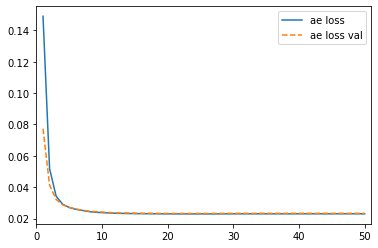

PR AUC: 0.26


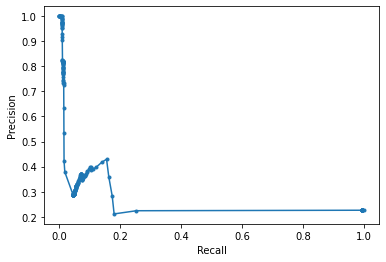

AUC: 0.51
Iteration: 2
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 783 seconds



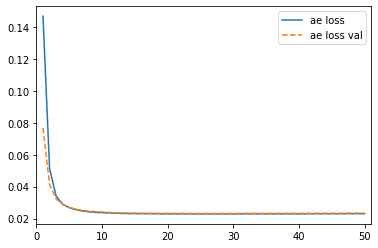

PR AUC: 0.27


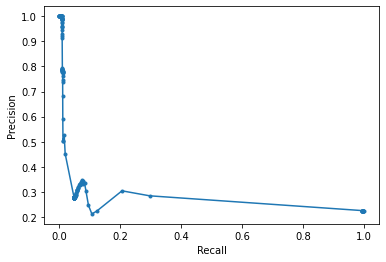

AUC: 0.54
Iteration: 3
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 781 seconds



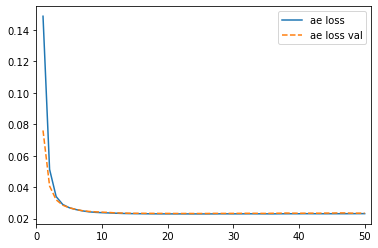

PR AUC: 0.20


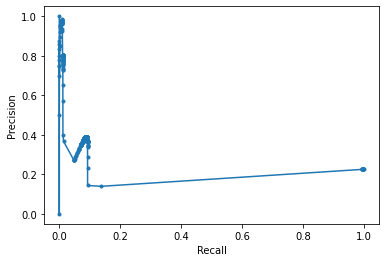

AUC: 0.45
Iteration: 4
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 779 seconds



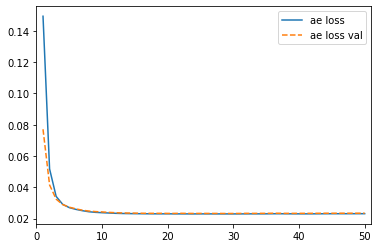

PR AUC: 0.26


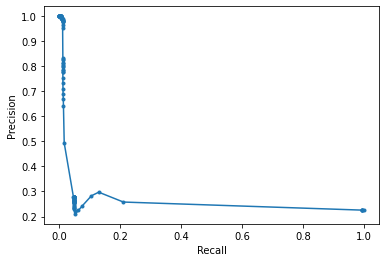

AUC: 0.52
Iteration: 5
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 771 seconds



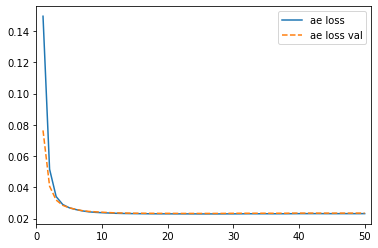

PR AUC: 0.24


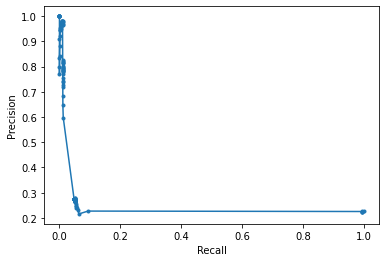

AUC: 0.50
Iteration: 6
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 780 seconds



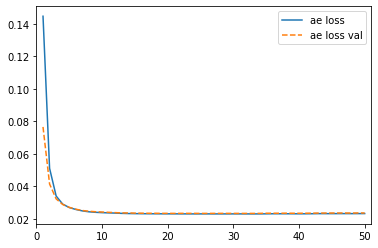

PR AUC: 0.29


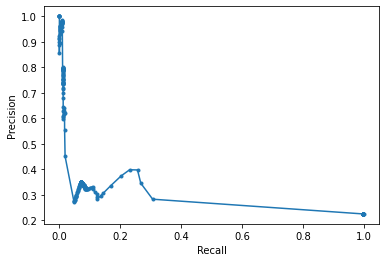

AUC: 0.55
Iteration: 7
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 767 seconds



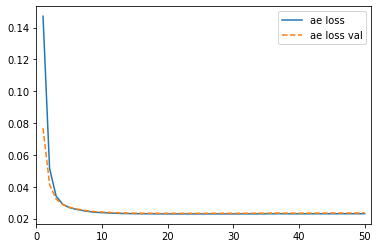

PR AUC: 0.28


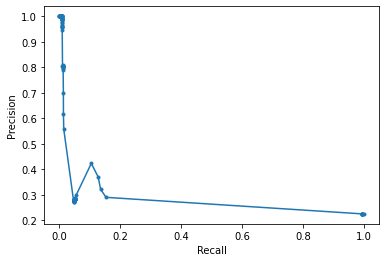

AUC: 0.52
Iteration: 8
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 764 seconds



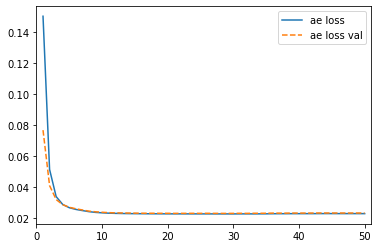

PR AUC: 0.23


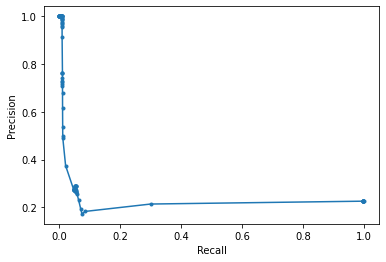

AUC: 0.49
Iteration: 9
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 767 seconds



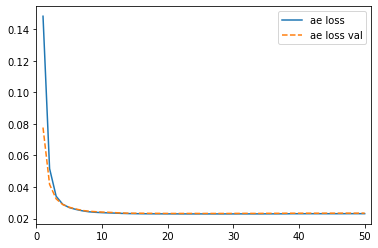

PR AUC: 0.33


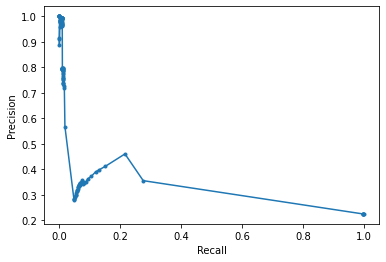

AUC: 0.57
Iteration: 10
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 766 seconds



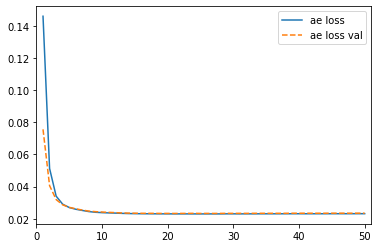

PR AUC: 0.34


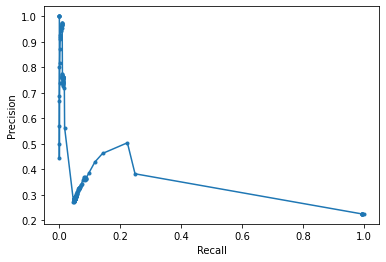

AUC: 0.57
Iteration: 11
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 775 seconds



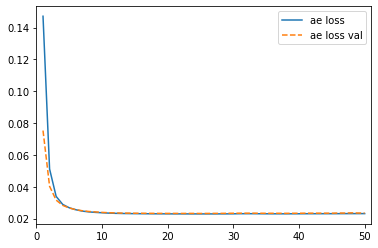

PR AUC: 0.27


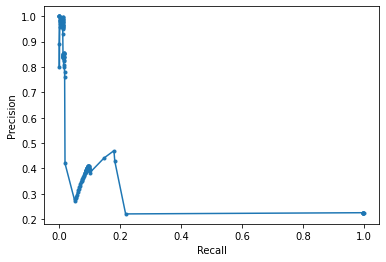

AUC: 0.51
Iteration: 12
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0232 
[INFO] Training phase... Elapsed time: 762 seconds



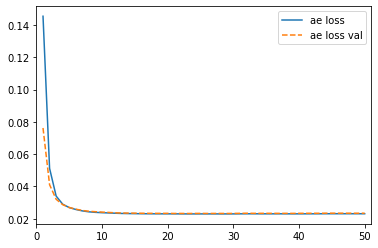

PR AUC: 0.33


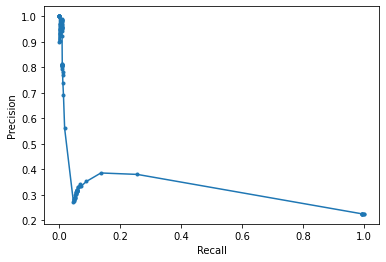

AUC: 0.57
Iteration: 13
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 762 seconds



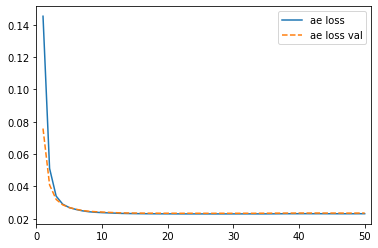

PR AUC: 0.29


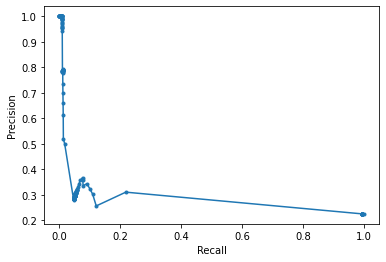

AUC: 0.54
Iteration: 14
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 765 seconds



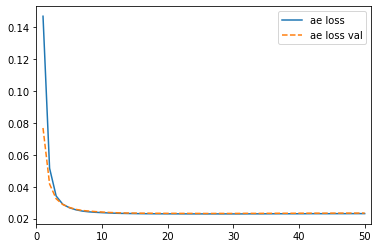

PR AUC: 0.46


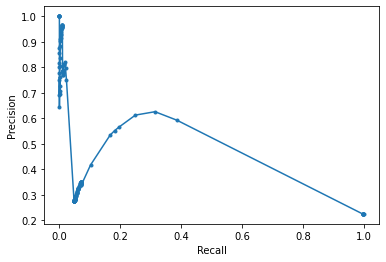

AUC: 0.65
Iteration: 15
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 759 seconds



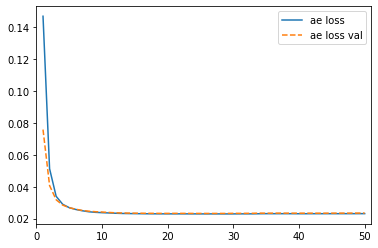

PR AUC: 0.24


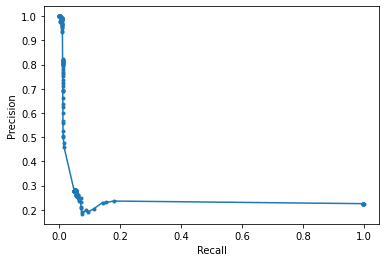

AUC: 0.50
Iteration: 16
[INFO] Starting training phase...
Epoch [ 27/50] | Step [250/434]| ae_loss: 0.0229 

In [ ]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CoverType(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = BaselineTrainer(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    ae_loss, ae_loss_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save Models
    AE_MODEL = f'BASELINE_{DATASET}_{i}.ckpt'
    torch.save(trainer.AE.state_dict(), os.path.join(SPACE_MODELS, AE_MODEL))
    
    y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(y_true, yP)
    pr = trainer.pr_auc(y_true, yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

Iteration: 16
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 707 seconds



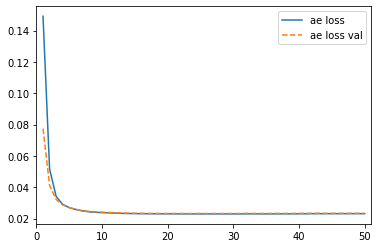

PR AUC: 0.31


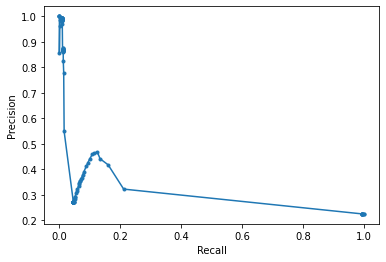

AUC: 0.54
Iteration: 17
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 691 seconds



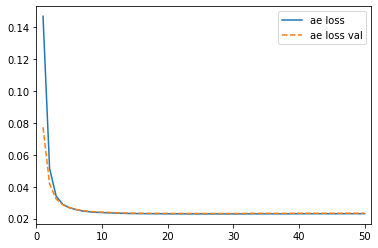

PR AUC: 0.18


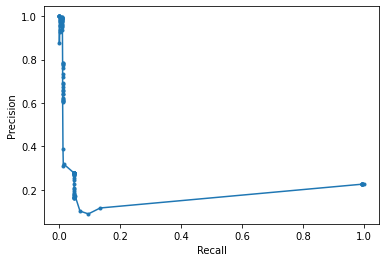

AUC: 0.42
Iteration: 18
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0232 
[INFO] Training phase... Elapsed time: 692 seconds



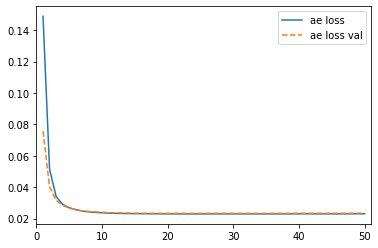

PR AUC: 0.35


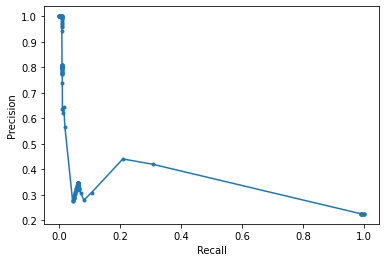

AUC: 0.59
Iteration: 19
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 703 seconds



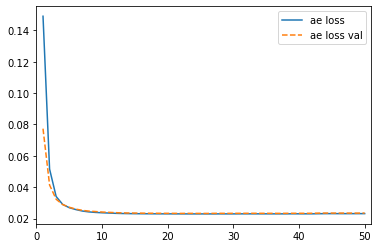

PR AUC: 0.27


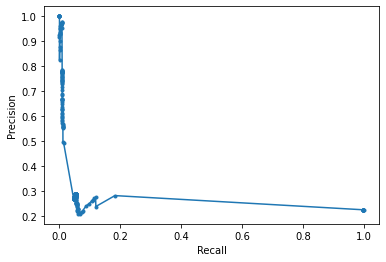

AUC: 0.52
Iteration: 20
[INFO] Starting training phase...
Epoch [ 50/50] | Step [430/434]| ae_loss: 0.0231 
[INFO] Training phase... Elapsed time: 705 seconds



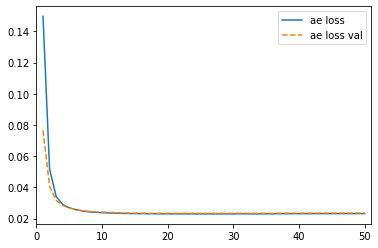

PR AUC: 0.33


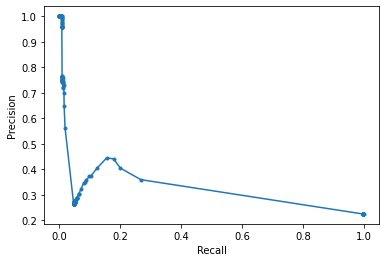

AUC: 0.57


In [ ]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(15, n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CoverType(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = BaselineTrainer(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    ae_loss, ae_loss_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save Models
    AE_MODEL = f'BASELINE_{DATASET}_{i}.ckpt'
    torch.save(trainer.AE.state_dict(), os.path.join(SPACE_MODELS, AE_MODEL))
    
    y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(y_true, yP)
    pr = trainer.pr_auc(y_true, yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

Iteration: 1
PR AUC: 0.28


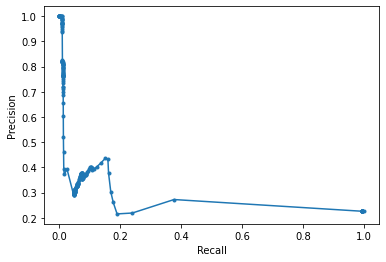

AUC: 0.54
Iteration: 2
PR AUC: 0.26


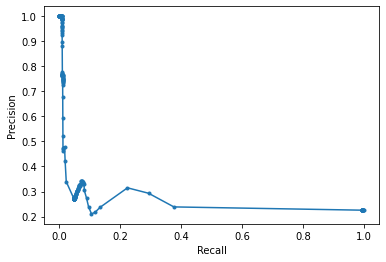

AUC: 0.52
Iteration: 3
PR AUC: 0.25


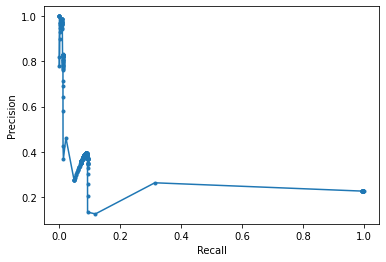

AUC: 0.51
Iteration: 4
PR AUC: 0.25


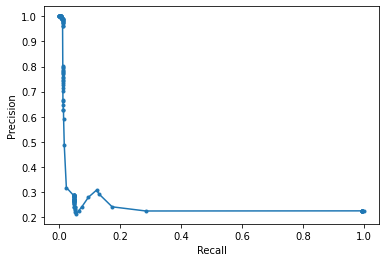

AUC: 0.50
Iteration: 5
PR AUC: 0.25


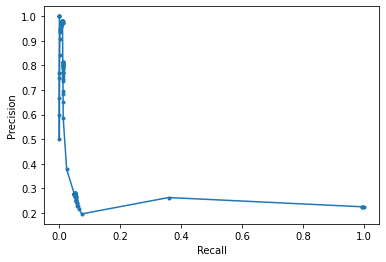

AUC: 0.53
Iteration: 6
PR AUC: 0.27


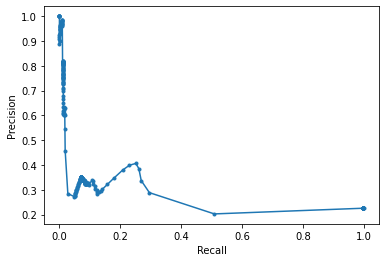

AUC: 0.50
Iteration: 7
PR AUC: 0.29


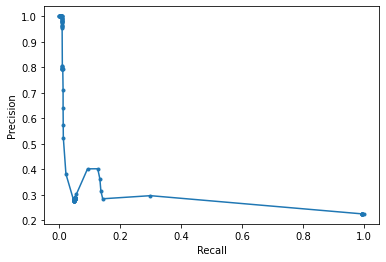

AUC: 0.55
Iteration: 8
PR AUC: 0.23


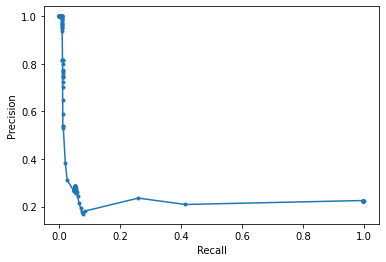

AUC: 0.48
Iteration: 9
PR AUC: 0.29


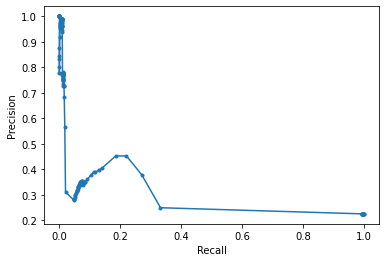

AUC: 0.54
Iteration: 10
PR AUC: 0.36


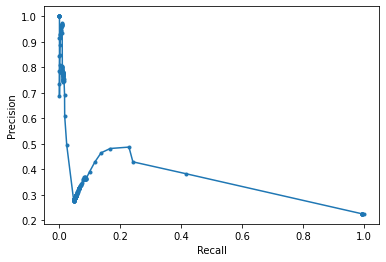

AUC: 0.62
Iteration: 11
PR AUC: 0.27


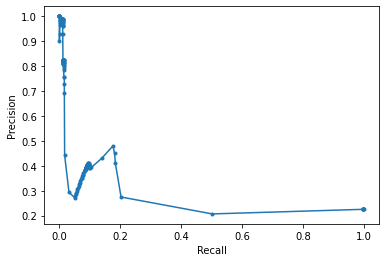

AUC: 0.50
Iteration: 12
PR AUC: 0.31


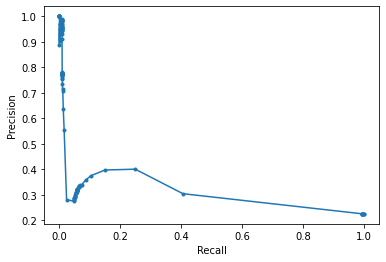

AUC: 0.58
Iteration: 13
PR AUC: 0.26


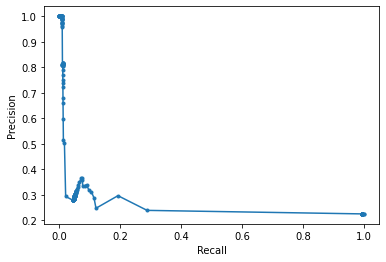

AUC: 0.52
Iteration: 14
PR AUC: 0.47


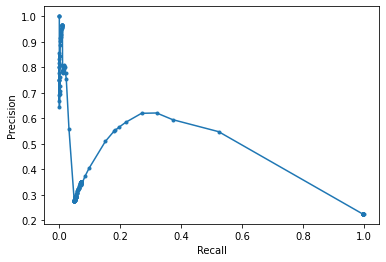

AUC: 0.70
Iteration: 15
PR AUC: 0.22


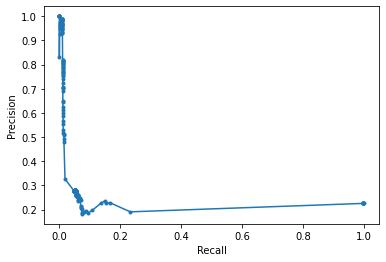

AUC: 0.48
Iteration: 16
PR AUC: 0.28


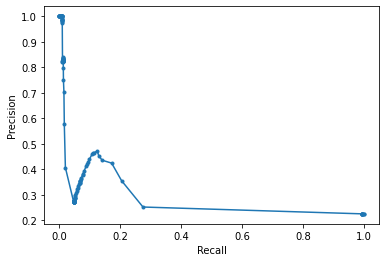

AUC: 0.53
Iteration: 17
PR AUC: 0.19


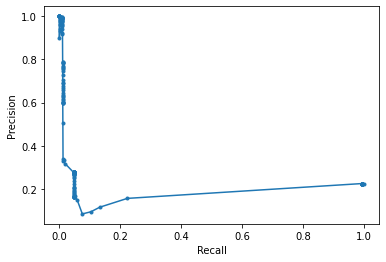

AUC: 0.43
Iteration: 18
PR AUC: 0.28


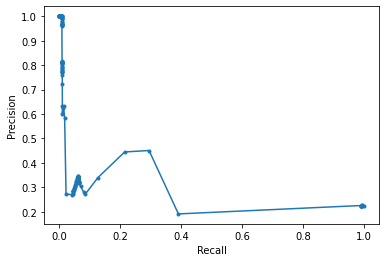

AUC: 0.50
Iteration: 19
PR AUC: 0.29


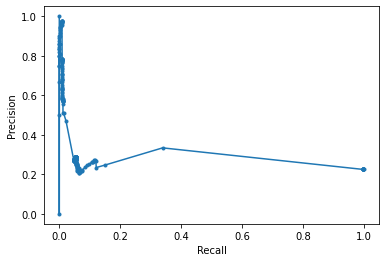

AUC: 0.56
Iteration: 20
PR AUC: 0.31


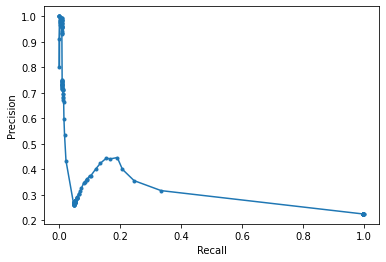

AUC: 0.57


In [7]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CoverType(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = BaselineTrainer(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    #ae_loss, ae_loss_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save Models
    AE_MODEL = f'BASELINE_{DATASET}_{i}.ckpt'
    #torch.save(trainer.AE.state_dict(), os.path.join(SPACE_MODELS, AE_MODEL))
    trainer.AE.load_state_dict(torch.load(os.path.join(SPACE_MODELS, AE_MODEL), map_location = torch.device(device)))
    
    y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(y_true, yP)
    pr = trainer.pr_auc(y_true, yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [8]:
meanAUC_PRAUC(auc_list, pr_list, 'Baseline_CoverType', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.5397241223774698, 0.5246691612040532, 0.5123233804985626, 0.5043770706930268, 0.5293248776878524, 0.5025215839343434, 0.5479366557450718, 0.48486321512206565, 0.5409571242256295, 0.615338527094213, 0.4952619120689458, 0.5791914312483621, 0.5170555491015261, 0.7001627716795944, 0.4776098233536592, 0.5308474431162291, 0.4266687776918856, 0.5020864616341886, 0.5635546643289764, 0.568301161140637]
**************
PR AUC:
[0.2763352951966006, 0.2593770850621538, 0.24904875756944703, 0.245099210786876, 0.2531210625962811, 0.26664671365289744, 0.28754368456722884, 0.22951330895147493, 0.2920715273500632, 0.35957633854224813, 0.26639280196172255, 0.31254819015246527, 0.2574944468379669, 0.474487294069487, 0.22288347803902311, 0.2846341130485341, 0.19237553092176685, 0.27570773136424753, 0.28940081853353583, 0.3123927325438893]
**************
AUC
0.53 +/- 0.02
95% confidence level, average auc would be between 0.51 and 0.56
**************
PR AUC
0.28 +/- 0.02
95% confidence level, averag

---